In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append('../')
from src.grid import *
from src import pml, pec_pmc
from eigenwell.src.constants import *

In [2]:
## why does assymeetry mess up our system?

In [23]:
N = np.array([100,240])
# plt.figure(figsize = (10,10))
# plt.spy(fd.Dyb, markersize = 2)
L = np.array([1e-6, 1e-6]);
dL= L/N
print(L)
xrange = [-L[0]/2, L[0]/2]
yrange = [-L[1]/2, L[1]/2]

x = np.linspace(xrange[0], xrange[1], N[0])
y = np.linspace(yrange[0], yrange[1], N[1])

X,Y = np.meshgrid(x,y, indexing = 'ij');
print(dL)

[1.e-06 1.e-06]
[1.00000000e-08 4.16666667e-09]


## PML test
Best way to test pml is FDFD driven

[100 240]
[-5e-07, 5e-07] [-5e-07, 5e-07]
[1.00000000e-08 4.16666667e-09] [100 240] [1.e-06 1.e-06]
(24000, 24000) (24000,)


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


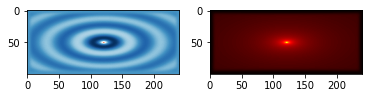

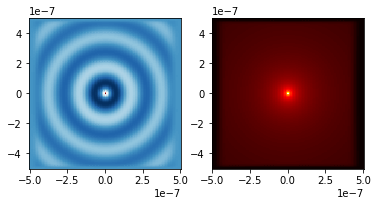

In [27]:
from scipy.sparse.linalg import spsolve as bslash
eps_r = np.ones(N)
wvlen = 0.2e-6;
Mz = np.zeros(N)

Npml = [15,15]
print(N)
Mz[N[0]//2,N[1]//2] = 1;

M = np.prod(N)
b = np.reshape(Mz, (M,), order = 'F'); #(Mz.flatten());

omega = 2*np.pi*C0/wvlen;

pml_obj = pml.PML(N,Npml, omega);
#self.Sxf, self.Syf, self.Sxb, self.Syb
Sxf, Syf, Sxb, Syb = pml_obj.Soperators(xrange, yrange);
print(xrange, yrange)


print(dL,N, dL*N)
fd = FiniteDifferenceGrid(dL,N)
fd.make_derivatives()

Tep = sp.spdiags(eps_r.flatten(), 0, np.prod(N), np.prod(N))

A = (Sxf@fd.Dxf)@(Sxb@fd.Dxb) + (Syf@fd.Dyf)@(Syb@fd.Dyb) + omega**2*MU0*EPSILON0*Tep;
print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.subplot(121)
plt.imshow(np.real(field), cmap = 'RdBu')
plt.subplot(122)
plt.imshow(np.abs(field), cmap = 'hot')
plt.show();

ax = plt.subplot(121)
plt.pcolormesh(X,Y, np.real(field), cmap = 'RdBu', shading = 'auto')
ax.set_aspect('equal')
ax = plt.subplot(122)
plt.pcolormesh(X,Y,np.abs(field), cmap = 'hot',shading = 'auto')
ax.set_aspect('equal')

plt.show();


(24000, 24000)


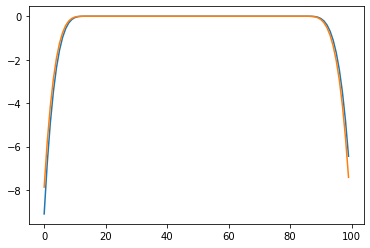

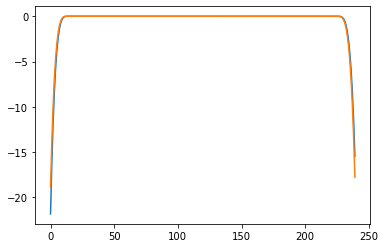

In [28]:
print(pml_obj.Sxf.shape)
plt.plot(np.imag(pml_obj.sxb))
plt.plot(np.imag(pml_obj.sxf))
plt.show();
plt.plot(np.imag(pml_obj.syb))
plt.plot(np.imag(pml_obj.syf))


## Symmetrization of PML

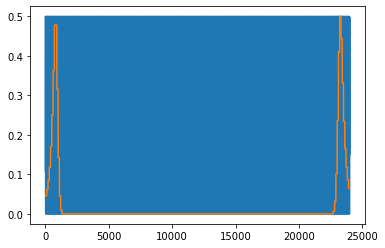

In [29]:
A = fd.Dxb@fd.Dxf + fd.Dyb@fd.Dyf + omega**2*MU0*EPSILON0*Tep;


sxb =  pml_obj.Sxb.diagonal();
syb = pml_obj.Syb.diagonal();

sxf =  pml_obj.Sxf.diagonal();
syf = pml_obj.Syf.diagonal();
## T

plt.plot(np.imag(sxb))
plt.plot(np.imag(syb))
plt.show();
 
# M = np.prod(N)
# numerator = np.sqrt(sxb)*np.sqrt(syb);
# denominator = 1/(numerator);
# Pr1 = sp.spdiags(numerator, 0, M,M);
# Pl1 = sp.spdiags(denominator,0,M,M);

# numerator = np.sqrt(sxf)*np.sqrt(syf);
# denominator = 1/(numerator);
# Pr2 = sp.spdiags(numerator, 0, M,M);
# Pl2 = sp.spdiags(denominator,0,M,M);

# print(Pr1.shape); #Pl^-1*(A*Pr^-1);

# symA = Pl1@(A@Pr1)

# #Pl^-1*(A*Pr^-1);
# print(symA)

In [16]:
print(sxb.shape)

(14000,)


## PEC_PMC


(14000, 14000) (14000,)


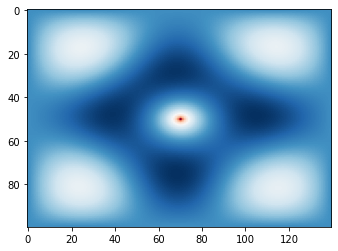

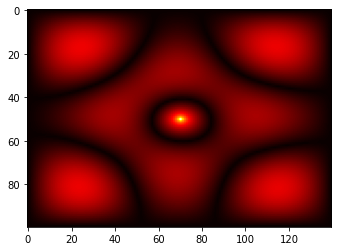

[[  0   1   2 ... 137 138 139]
 [  0   1   2 ... 137 138 139]
 [  0   1   2 ... 137 138 139]
 ...
 [  0   1   2 ... 137 138 139]
 [  0   1   2 ... 137 138 139]
 [  0   1   2 ... 137 138 139]]


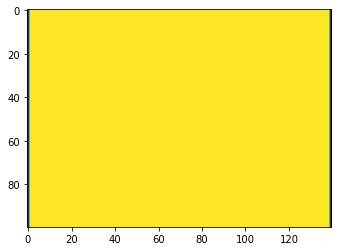

In [19]:
pec_pmc_obj = pec_pmc.PEC_PMC(N)
mx= pec_pmc_obj.mask_x;
my = pec_pmc_obj.mask_y;
wvlen = 0.5e-6;
omega = 2*np.pi*C0/wvlen;


fd = FiniteDifferenceGrid(dL,N)

A = mx@my@((fd.Dxf)@(fd.Dxb) + (fd.Dyf)@(fd.Dyb))@my@mx + omega**2*MU0*EPSILON0*Tep;

print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.imshow(np.real(field), cmap = 'RdBu')
plt.show();

plt.imshow(np.abs(field), cmap = 'hot')
plt.show();


#plt.imshow(pec_pmc_obj.mask_y.diagonal().reshape(N, order = 'F'))

xn = list(range(N[0]));
yn = list(range(N[1]));

## ordering should be 'F' contiguous
[Xn,Yn] = np.meshgrid(xn,yn, indexing = 'ij');

print(Yn)

(14000, 14000) (14000,)


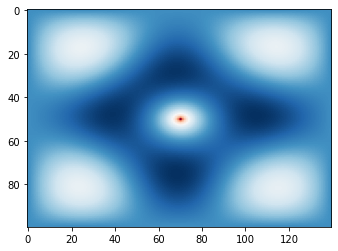

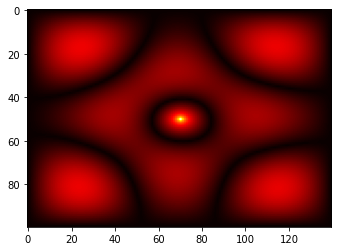

In [22]:
def grid_average(center_array, w):
    '''
        sdf;
    '''
    # computes values at cell edges

    xy = {'x': 0, 'y': 1}
    center_shifted = np.roll(center_array, 1, axis=xy[w])
    avg_array = (center_shifted+center_array)/2
    return avg_array


mx= pec_pmc_obj.mask_x;
my = pec_pmc_obj.mask_y;
wvlen = 0.5e-6;
omega = 2*np.pi*C0/wvlen;

epxx = grid_average(eps_r,'x')
epyy = grid_average(eps_r, 'y')

invTepxx = sp.spdiags(1/epxx.flatten(),0,M,M);
invTepyy = sp.spdiags(1/epyy.flatten(),0,M,M);

fd = FiniteDifferenceGrid(dL,N)
I = sp.identity(M)
A = (mx@fd.Dxf)@(invTepxx)@(fd.Dxb@mx) + (my@fd.Dyf)@(invTepyy)@(fd.Dyb@my) + omega**2*MU0*EPSILON0*I;

print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.imshow(np.real(field), cmap = 'RdBu')
plt.show();

plt.imshow(np.abs(field), cmap = 'hot')
plt.show();

## Assymetric Structures, assymetric PML

like a waveguide or a plane wave

[100 240]
[-5e-07, 5e-07] [-5e-07, 5e-07]
[1.00000000e-08 4.16666667e-09] [100 240] [1.e-06 1.e-06]
(24000, 24000) (24000,)


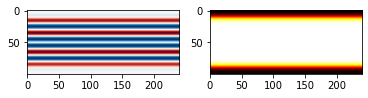

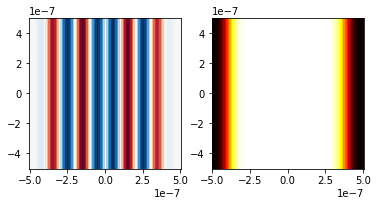

In [35]:
from scipy.sparse.linalg import spsolve as bslash
eps_r = np.ones(N)
wvlen = 0.2e-6;
Mz = np.zeros(N)

Npml = [30,0]
print(N)
#Mz[:,N[1]//2] = 1;
Mz[N[0]//2,:] = 1;

M = np.prod(N)
b = np.reshape(Mz, (M,), order = 'F'); #(Mz.flatten());

omega = 2*np.pi*C0/wvlen;

pml_obj = pml.PML(N,Npml, omega);
#self.Sxf, self.Syf, self.Sxb, self.Syb
Sxf, Syf, Sxb, Syb = pml_obj.Soperators(xrange, yrange);
print(xrange, yrange)


print(dL,N, dL*N)
fd = FiniteDifferenceGrid(dL,N)
fd.make_derivatives()

Tep = sp.spdiags(eps_r.flatten(), 0, np.prod(N), np.prod(N))

A = (Sxf@fd.Dxf)@(Sxb@fd.Dxb) + (Syf@fd.Dyf)@(Syb@fd.Dyb) + omega**2*MU0*EPSILON0*Tep;
print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.subplot(121)
plt.imshow(np.real(field), cmap = 'RdBu')
plt.subplot(122)
plt.imshow(np.abs(field), cmap = 'hot')
plt.show();

ax = plt.subplot(121)
plt.pcolormesh(X,Y, np.real(field), cmap = 'RdBu', shading = 'auto')
ax.set_aspect('equal')
ax = plt.subplot(122)
plt.pcolormesh(X,Y,np.abs(field), cmap = 'hot',shading = 'auto')
ax.set_aspect('equal')

plt.show();
